# Personal VAD architecture evaluation
This notebook serves as a tool for model evaluation. Contrary to the evaluate_models.py script, this notebook 
can help evaluate each model individually.

The notebook NEEDS access to the `data/eval_dir/` directory to work correctly -- simply run the notebook inside the `src/`
directory to ensure this.

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import kaldiio
import torch
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pack_padded_sequence, pad_sequence
from sklearn.metrics import average_precision_score, confusion_matrix, accuracy_score, ConfusionMatrixDisplay

from personal_vad import PersonalVAD, pad_collate
from vad import VadDataset
from vad_et import VadETDataset
from vad_set import VadSETDataset
from vad_st import VadSTDataset
from vad_xvector import VadETDatasetX
from vad_ivector import VadETDatasetI
from evaluate_models import parse_model_name

CUDA available. torch.version.cuda=11.7, cuda_count=1, device_name=NVIDIA GeForce RTX 4060 Laptop GPU


## AP, mAP, confusion matrix, accuracy personal VAD evaluation
Before proceeding, select the evaluated model name, and if necessary, specify the name of your evaluation dataset. The
evaluated model HAS to reside in the ``data/eval_dir/models/`` directory, the data folder HAS to reside in ``data/eval_dir/data/``

In [3]:
# move to the evaluation directory.. if this is causing you problems, just
# set the eval_dir variable to the absolute path of 'data/eval_dir' on your system...
eval_dir = 'C:\Work\Coding\Diarization\PersonalVAD\personalVAD\data\eval_dir'
print(os.getcwd())
os.chdir(eval_dir)
print(os.getcwd())

c:\Work\Coding\Diarization\PersonalVAD\personalVAD\src
C:\Work\Coding\Diarization\PersonalVAD\personalVAD\data\eval_dir


In [31]:
# set these up to your liking...
model = 'vad_et_10ep_linear_ivec_l2.pt'
eval_set = 'data/features_full'
batch_size = 64

In [33]:
# get the model information
ret = parse_model_name(model)
if ret == None: print("Invalid or unsupported model name supplied..")
(arch, embed, use_fc, linear, score_type, input_dim) = ret

model_path = 'models/' + model


# load the model, prepare the datset and data loader...
net = PersonalVAD(input_dim=input_dim, hidden_dim=64, num_layers=2,
        out_dim=3, use_fc=use_fc, linear=linear)
net.load_state_dict(torch.load(model_path))

# create the corresponding dataset objects with the correct
# target speaker embedding directory selected
if arch == 'et':
    if embed == 'dvec':
        test_data = VadETDataset(eval_set, 'embeddings')
    elif embed == 'xvec':
        test_data = VadETDatasetX(eval_set, 'embeddings_xvec_l2')

    else: # ivec
        if 'l2' in model:
            print(eval_set)
            test_data = VadETDatasetI(eval_set, 'embeddings_ivec_l2')
        else:
            test_data = VadETDatasetI(eval_set, 'embeddings_ivec')

elif arch == 'set':
    test_data = VadSETDataset(eval_set, 'embeddings', score_type)

elif arch == 'st':
    test_data = VadSTDataset(eval_set, score_type)

else:
    # we should not get here
    print("We actually got here -__-")

# setup the data loader
test_loader = DataLoader(dataset=test_data, batch_size=batch_size,
        num_workers=2, shuffle=False, collate_fn=pad_collate)

# set the device to cuda and move the model to the gpu
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
net = net.to(device)


data/features_full


In [34]:
# mAP evaluation
softmax = torch.nn.Softmax(dim=1)
targets = []
outputs = []

with torch.no_grad():
    
    for x_padded, y_padded, x_lens, y_lens in test_loader:
        y_padded = y_padded.to(device)

        # pass the data through the model
        out_padded, _ = net(x_padded.to(device), x_lens, None)

        # value, index
        for j in range(out_padded.size(0)):
            p = softmax(out_padded[j][:y_lens[j]])
            outputs.append(p.cpu().numpy())
            targets.append(y_padded[j][:y_lens[j]].cpu().numpy())
                
targets = np.concatenate(targets)
outputs = np.concatenate(outputs)
print(targets.shape)
print(outputs.shape)

(60118755,)
(60118755, 3)


In [35]:
# convert the target array to one hot
targets_oh = np.eye(3)[targets]

# and run the AP
out_AP = average_precision_score(targets_oh, outputs, average=None)
mAP = average_precision_score(targets_oh, outputs, average='micro')

# print the average precision scores for all classes as well as the micro-averaged mean average precision score
print(model)
print('  ns   |   ntss   |   tss') 
print(out_AP) 
print(f"mAP: {mAP}")

vad_et_10ep_linear_ivec_l2.pt
  ns   |   ntss   |   tss
[0.87087101 0.95892042 0.95712741]
mAP: 0.9466494398341024


vad_et_10ep_linear_ivec_l2.pt
accuracy: 0.8760942571082851


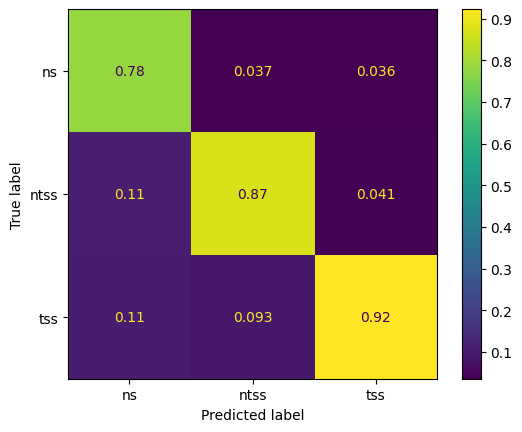

In [36]:
# compute and plot the model confusion matrix
classes = np.argmax(outputs, axis=1)
cm = confusion_matrix(classes, targets, normalize='pred')

disp = ConfusionMatrixDisplay(confusion_matrix=cm,  display_labels=['ns', 'ntss', 'tss'])
disp.plot()

# compute model classification accuracy
acc = accuracy_score(classes, targets)
print(model)
print("accuracy:", acc)

## Baseline VAD evaluation
This part of the notebook can be used for the evaluation of the baseline speech/non-speech VAD system.

In [38]:
# make sure we are in the correct directory..
eval_dir = 'C:\Work\Coding\Diarization\PersonalVAD\personalVAD\data\eval_dir'
print(os.getcwd())
os.chdir(eval_dir)
print(os.getcwd())

C:\Work\Coding\Diarization\PersonalVAD\personalVAD\data\eval_dir
C:\Work\Coding\Diarization\PersonalVAD\personalVAD\data\eval_dir


In [39]:
# set these up to your liking, as above..
model = 'vad_tanh_6ep.pt'
model_path = 'models/' + model
eval_data = 'data/test'
batch_size = 64

In [40]:
linear = False if 'tanh' in model else False

# load the model and setup the dataset object
net = PersonalVAD(input_dim=40, hidden_dim=64, num_layers=2, out_dim=2, linear=linear)
net.load_state_dict(torch.load(model_path))
test_data = VadDataset(eval_data)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
net = net.to(device)

test_loader = DataLoader(
        dataset=test_data, batch_size=batch_size, num_workers=2, shuffle=False, collate_fn=pad_collate)

In [41]:
# mAP evaluation
softmax = torch.nn.Softmax(dim=1)
targets = []
outputs = []

with torch.no_grad():
    for x_padded, y_padded, x_lens, y_lens in test_loader:
        y_padded = y_padded.to(device)

        # pass the data through the model
        out_padded, _ = net(x_padded.to(device), x_lens, None)

        # value, index
        for j in range(out_padded.size(0)):
            p = out_padded[j][:y_lens[j]]
            
            outputs.append(p.cpu().numpy())
            targets.append(y_padded[j][:y_lens[j]].cpu().numpy())
                
targets = np.concatenate(targets)
outputs = np.concatenate(outputs)
print(targets.shape)
print(outputs.shape)

(3118152,)
(3118152, 2)


In [42]:
# convert the target array to one hot
targets_oh = np.eye(2)[targets.astype(int)]
outputs_oh = np.hstack((1 - outputs, outputs))

# and compute the AP scores
out_AP = average_precision_score(targets_oh, outputs, average=None)
mAP = average_precision_score(targets_oh, outputs, average='micro')

print(model)
print('  speech   |   non-speech') 
print(out_AP) 
print(f"mAP: {mAP}")
print("accuracy:", accuracy_score(targets, np.argmax(outputs, axis=1)))

vad_tanh_6ep.pt
  speech   |   non-speech
[0.91025233 0.99668702]
mAP: 0.9912902979800795
accuracy: 0.9512425949729199


# Baseline SC system
This part of the notebook can be used for the baseline SC system evaluation.

In [44]:
# make sure we are in the correct directory..
eval_dir = 'C:\Work\Coding\Diarization\PersonalVAD\personalVAD\data\eval_dir'
print(os.getcwd())
os.chdir(eval_dir)
print(os.getcwd())

C:\Work\Coding\Diarization\PersonalVAD\personalVAD\data\eval_dir
C:\Work\Coding\Diarization\PersonalVAD\personalVAD\data\eval_dir


In [45]:
# set these up to your liking, as above..
model = 'vad_linear_6ep.pt'
model_path = 'models/' + model
eval_data = 'data/test'
score_type = 0
batch_size = 64

# set the EER threshold value depending on the d-vector extraction method for the SC modification
EER_threshold = 0.5329 if score_type == 0 else 0.5822

In [46]:
class BaselineDataset(Dataset):
    """VadSC training dataset class. Uses kaldi scp and ark files.
    
    This dataset class had to be created explicitly for the SC architecture, as there
    are some specifics none of the other dataset classes really cover.
    """

    def __init__(self, root_dir, score_type):
        self.root_dir = root_dir
        self.score_type = score_type

        self.fbanks = kaldiio.load_scp(f'{self.root_dir}/fbanks.scp')
        self.scores = kaldiio.load_scp(f'{self.root_dir}/scores.scp')
        self.labels = kaldiio.load_scp(f'{self.root_dir}/labels.scp')
        self.keys = np.array(list(self.fbanks)) # get all the keys

    def __len__(self):
        return self.keys.size

    def __getitem__(self, idx):
        key = self.keys[idx]
        x = self.fbanks[key]
        scores = self.scores[key][self.score_type,:]
        y = self.labels[key]

        x = torch.from_numpy(x).float()
        scores = torch.from_numpy(scores).float()
        y = torch.from_numpy(y).long()
        return x, scores, y

def baseline_pad_collate(batch):
    """Padding function used to deal with batches of sequences of variable lengths for
    the baseline SC PVAD system.
    
    The scores are not padded and have to be returned as separate tensors, not
    as parts of the input features.
    """

    (xx, scores, yy) = zip(*batch)
    x_lens = [len(x) for x in xx]
    y_lens = [len(y) for y in yy]
    x_padded = pad_sequence(xx, batch_first=True, padding_value=0)
    y_padded = pad_sequence(yy, batch_first=True, padding_value=0)
    return x_padded, y_padded, scores, x_lens, y_lens

In [ ]:
linear = False if 'tanh' in model else True

# load the model, setup the dataset object
net = PersonalVAD(input_dim=40, hidden_dim=64, num_layers=2, out_dim=2, linear=linear)
net.load_state_dict(torch.load(model_path))
test_data = BaselineDataset(eval_data, score_type)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
net = net.to(device)

# create the dataloader object
test_loader = DataLoader(
        dataset=test_data, batch_size=batch_size, num_workers=0, shuffle=False, collate_fn=baseline_pad_collate)

In [49]:
# mAP evaluation
softmax = torch.nn.Softmax(dim=1)
targets = []
outputs = []
is_tss = []

with torch.no_grad():
    for x_padded, y_padded, scores, x_lens, y_lens in test_loader:
        # pass the data through the model
        out_padded, _ = net(x_padded.to(device), x_lens, None)

        # value, index
        for j in range(out_padded.size(0)):
            score = scores[j]
            x = out_padded[j][:y_lens[j]].cpu()
            x = softmax(x)
            
            # now combine the scores with the vad probability to obtain class probabilities
            ns = x[:,0]
            ntss = x[:,1] * (1 - score)
            tss = x[:,1] * score
            
            # baseline modification - produces 1D predicted class index array
            # this is a bit of a mess, just bare with me..
            x2 = x.numpy()
            score2 = score.numpy()
            b = (x2[:,0] < x2[:,1]).astype('int') # 0 if ns, 1 if speech
            c = (score2 > EER_threshold).astype('int') # 0 if ntss, 1 if tss
            d = ((b == c) & (b != 0)).astype('int') * 2 #  2 if tss, 0 else
            e = np.where((c == 0) & (b != 0), 1, 0)
            is_tss.append(d + e)
            
            out = torch.stack((ns, ntss, tss)).T
            out = softmax(out)
            
            outputs.append(out.numpy())
            targets.append(y_padded[j][:y_lens[j]].numpy())
                
targets = np.concatenate(targets)
outputs = np.concatenate(outputs)
is_tss = np.concatenate(is_tss)
print(targets.shape)
print(outputs.shape)

BrokenPipeError: [Errno 32] Broken pipe

In [ ]:
# convert the target array to one hot
targets_oh = np.eye(3)[targets]

# and run the AP
out_AP = average_precision_score(targets_oh, outputs, average=None)
mAP = average_precision_score(targets_oh, outputs, average='micro')

print(model)
print(out_AP) 
print(f"mAP: {mAP}")
print("accuracy:", accuracy_score(targets, np.argmax(outputs, axis=1)))

In [ ]:
# evaluate the accuracy of the SC EER threshold modification
print(model)
print("accuracy:", accuracy_score(targets, is_tss))